# Thư viện

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
# from common.utils import load_data, mape

# Dữ liệu

In [2]:
df = pd.read_csv("./gasoline_prices.csv")
df.head()

,date,RON_95III,RON_95II,DO_05SII,KO
0,8/22/2018,21.17,19.61,17.68,16.26
1,8/23/2018,21.47,19.91,18.06,16.55
2,8/24/2018,21.47,19.91,18.06,16.55
3,8/25/2018,21.47,19.91,18.06,16.55
4,8/26/2018,21.47,19.91,18.06,16.55


In [3]:
df['date'] = pd.to_datetime(df['date'])
df_gasolinePrices = df.loc[:, ['date', 'RON_95III']]
df_gasolinePrices.set_index('date', inplace=True)
df_gasolinePrices

,RON_95III
date,
2018-08-22,21.17
2018-08-23,21.47
2018-08-24,21.47
2018-08-25,21.47
2018-08-26,21.47
...,...
2023-10-19,23.51
2023-10-20,23.51
2023-10-21,23.51


In [4]:
# Chia tập dữ liệu thành tập train và test (80% train, 20% test)
train_size = 0.8
split_index = int(len(df_gasolinePrices) * train_size)
train, test = df_gasolinePrices[:split_index], df_gasolinePrices[split_index:]
print("train:", len(train))
print("test:", len(test))

train: 1511
test: 378


<Figure size 1500x800 with 0 Axes>

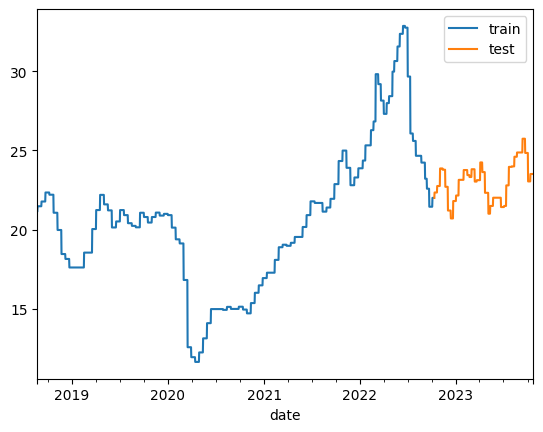

In [5]:
plt.figure(figsize=(15,8))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [6]:
print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1511, 1)
Test data shape:  (378, 1)


In [7]:
scaler = MinMaxScaler()
train['RON_95III'] = scaler.fit_transform(train)
test['RON_95III'] = scaler.fit_transform(test)

C:\Users\haonh\AppData\Local\Temp\ipykernel_19452\1782848237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['RON_95III'] = scaler.fit_transform(train)
C:\Users\haonh\AppData\Local\Temp\ipykernel_19452\1782848237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['RON_95III'] = scaler.fit_transform(test)


In [8]:
# Converting to numpy arrays
train_data = train.values
test_data = test.values

In [9]:
timesteps=5

In [10]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(1507, 5)

In [11]:
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(374, 5)

In [ ]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# SVM

In [13]:
model = SVR(kernel='rbf',gamma=0.05, C=100, epsilon = 0.05)

In [14]:
model.fit(x_train, y_train[:,0])

SVR(C=100, epsilon=0.05, gamma=0.05)

In [15]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(1507, 1) (374, 1)


In [16]:
# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

print(len(y_train_pred), len(y_test_pred))

1507 374


In [17]:
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

1507 374


In [18]:
from sklearn.metrics import mean_squared_error
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'RMSE on training set: {rmse_train}')
print(f'RMSE on testing set: {rmse_test}')

RMSE on training set: 0.07437113587704483
RMSE on testing set: 0.2686448332291724


# XGboost

In [31]:
from xgboost import XGBRegressor

import xgboost as xgb

# Chuẩn bị dữ liệu cho XGBoost
xgb_train = xgb.DMatrix(x_train, label=y_train)
xgb_test = xgb.DMatrix(x_test, label=y_test)

In [32]:
# Thiết lập các tham số cho mô hình XGBoost
params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5,
    'alpha': 10,
    'n_estimators': 100
}

# Xây dựng mô hình XGBoost
model_xgb = XGBRegressor(**params)

# Huấn luyện mô hình
model_xgb.fit(x_train, y_train)


XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [33]:
# Dự đoán trên tập huấn luyện và tập kiểm thử
y_train_pred_xgb = model_xgb.predict(x_train)
y_test_pred_xgb = model_xgb.predict(x_test)

# Tính toán RMSE
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
print(f'RMSE on training set (XGBoost): {rmse_train_xgb}')
print(f'RMSE on testing set (XGBoost): {rmse_test_xgb}')

RMSE on training set (XGBoost): 0.09490717787091979
RMSE on testing set (XGBoost): 0.35567631953149187


# Random Forest

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
# Thiết lập các tham số cho mô hình Random Forest
rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'random_state': 42
}

# Xây dựng mô hình Random Forest
model_rf = RandomForestRegressor(**rf_params)

# Huấn luyện mô hình
model_rf.fit(x_train, y_train.ravel())


RandomForestRegressor(max_depth=10, random_state=42)

In [37]:
# Dự đoán trên tập huấn luyện và tập kiểm thử
y_train_pred_rf = model_rf.predict(x_train)
y_test_pred_rf = model_rf.predict(x_test)

# Tính toán RMSE
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
print(f'RMSE on training set (Random Forest): {rmse_train_rf}')
print(f'RMSE on testing set (Random Forest): {rmse_test_rf}')


RMSE on training set (Random Forest): 0.05809256043381007
RMSE on testing set (Random Forest): 0.253292666443078
